# Tutorial 2: Customizing Surrogate Gradients for SNNs

This tutorial teaches you how to **create custom surrogate gradient functions** tailored to your specific needs. We'll cover:

1. **Understanding the Surrogate API** - Base class and structure
2. **Creating Custom Surrogates** - Step-by-step implementation
3. **Advanced Techniques** - Asymmetric, adaptive, and learned surrogates
4. **Functional API** - Using surrogates without classes
5. **Best Practices** - Design principles and optimization
6. **Real-World Examples** - Task-specific surrogates

## Setup

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import braintools.surrogate as surrogate
from brainstate.util import PrettyObject

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Setup complete!")

Setup complete!


## 1. Understanding the Surrogate API

All surrogate gradient functions in `braintools` inherit from the `Surrogate` base class:

```python
class Surrogate(PrettyObject):
    def __call__(self, x):
        """Forward pass: returns Heaviside step function."""
        dx = self.surrogate_grad(x)
        return heaviside_p.bind(x, dx)[0]
    
    def surrogate_fun(self, x) -> jax.Array:
        """The smooth surrogate function (for visualization)."""
        raise NotImplementedError
    
    def surrogate_grad(self, x) -> jax.Array:
        """The gradient of the surrogate function (used in backprop)."""
        raise NotImplementedError
```

To create a custom surrogate, you need to:
1. Inherit from `Surrogate`
2. Implement `surrogate_fun(x)` - the smooth approximation
3. Implement `surrogate_grad(x)` - its gradient

Let's start with a simple example!

## 2. Creating a Simple Custom Surrogate

### Example 1: Triangular Surrogate

Let's create a surrogate with a triangular gradient shape:

$$\sigma'(x) = \max(0, 1 - |x|)$$

=== CUSTOM TRIANGULAR SURROGATE ===


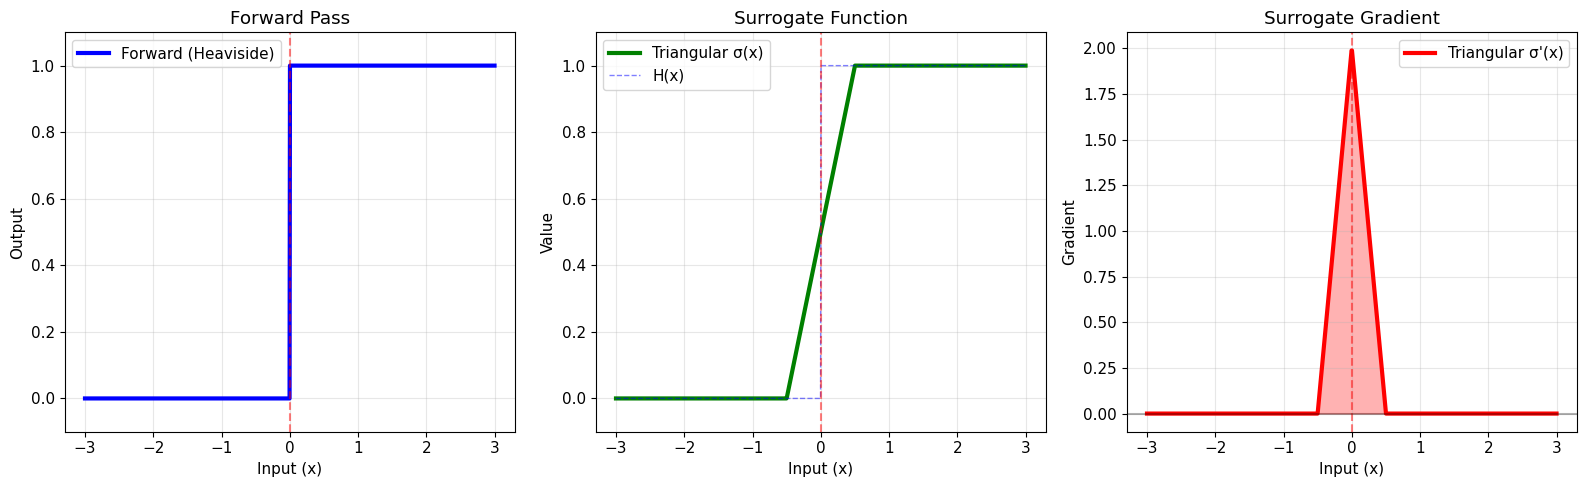

✅ Custom triangular surrogate created successfully!

Key features:
• Finite support: gradient is zero outside [-1/α, 1/α]
• Linear gradient decay
• Peak gradient at x=0


In [2]:
# Create a custom triangular surrogate
print("=== CUSTOM TRIANGULAR SURROGATE ===")

class TriangularSurrogate(surrogate.Surrogate):
    """Surrogate with triangular gradient."""
    
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha
    
    def surrogate_fun(self, x):
        """Piecewise linear approximation to Heaviside."""
        # Linear interpolation from 0 to 1 around threshold
        return jnp.clip(0.5 + x * self.alpha / 2, 0.0, 1.0)
    
    def surrogate_grad(self, x):
        """Triangular gradient: max(0, 1 - |x|)."""
        return jnp.maximum(0.0, self.alpha * (1.0 - jnp.abs(x * self.alpha)))

# Test the custom surrogate
tri_surrogate = TriangularSurrogate(alpha=2.0)

x = jnp.linspace(-3, 3, 1000)

# Compute values
forward_output = tri_surrogate(x)
surrogate_fun = tri_surrogate.surrogate_fun(x)
surrogate_grad = tri_surrogate.surrogate_grad(x)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Forward pass
axes[0].plot(x, forward_output, 'b-', linewidth=3, label='Forward (Heaviside)')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Input (x)')
axes[0].set_ylabel('Output')
axes[0].set_title('Forward Pass')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.1, 1.1)

# Surrogate function
axes[1].plot(x, surrogate_fun, 'g-', linewidth=3, label='Triangular σ(x)')
axes[1].plot(x, forward_output, 'b--', linewidth=1, alpha=0.5, label='H(x)')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Input (x)')
axes[1].set_ylabel('Value')
axes[1].set_title('Surrogate Function')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-0.1, 1.1)

# Gradient
axes[2].plot(x, surrogate_grad, 'r-', linewidth=3, label="Triangular σ'(x)")
axes[2].fill_between(x, 0, surrogate_grad, alpha=0.3, color='red')
axes[2].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[2].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[2].set_xlabel('Input (x)')
axes[2].set_ylabel('Gradient')
axes[2].set_title('Surrogate Gradient')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Custom triangular surrogate created successfully!")
print("\nKey features:")
print("• Finite support: gradient is zero outside [-1/α, 1/α]")
print("• Linear gradient decay")
print("• Peak gradient at x=0")

In [3]:
# Test gradient computation
print("=== TESTING CUSTOM SURROGATE ===")

def loss_fn(x):
    return jnp.sum(tri_surrogate(x))

test_x = jnp.array([0.0, 0.5, 1.0])
gradient = jax.grad(loss_fn)(test_x)

print(f"Input: {test_x}")
print(f"Forward: {tri_surrogate(test_x)}")
print(f"Gradient: {gradient}")
print("\n✅ Gradient computation works correctly!")

=== TESTING CUSTOM SURROGATE ===
Input: [0.  0.5 1. ]
Forward: [1. 1. 1.]
Gradient: [2. 0. 0.]

✅ Gradient computation works correctly!


## 3. Advanced Custom Surrogates

### Example 2: Asymmetric Surrogate

Sometimes you want different gradient behavior for values above vs below threshold:

=== ASYMMETRIC SURROGATE ===


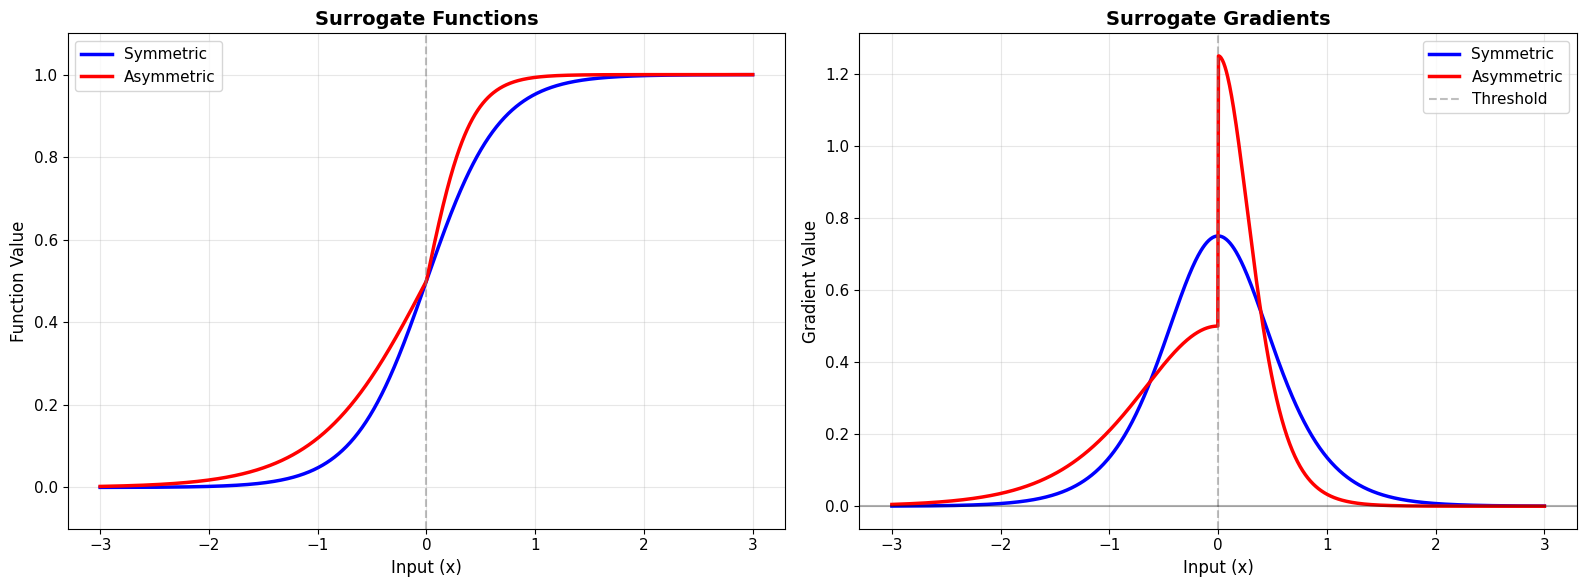


✅ Asymmetric surrogate allows different learning rates
   for encouraging vs discouraging spikes!

Use cases:
• Stronger gradient below threshold → encourage spiking
• Stronger gradient above threshold → discourage spiking
• Useful for sparse coding or energy efficiency


In [4]:
# Asymmetric surrogate with different gradients above/below threshold
print("=== ASYMMETRIC SURROGATE ===")

class AsymmetricSurrogate(surrogate.Surrogate):
    """Asymmetric surrogate with different gradients for positive/negative."""
    
    def __init__(self, alpha_pos=4.0, alpha_neg=2.0):
        super().__init__()
        self.alpha_pos = alpha_pos  # Steepness above threshold
        self.alpha_neg = alpha_neg  # Steepness below threshold
    
    def surrogate_fun(self, x):
        """Asymmetric sigmoid."""
        # Use different alpha for positive and negative x
        alpha = jnp.where(x >= 0, self.alpha_pos, self.alpha_neg)
        return 1.0 / (1.0 + jnp.exp(-alpha * x))
    
    def surrogate_grad(self, x):
        """Derivative of asymmetric sigmoid."""
        alpha = jnp.where(x >= 0, self.alpha_pos, self.alpha_neg)
        sig = self.surrogate_fun(x)
        return alpha * sig * (1.0 - sig)

# Compare symmetric vs asymmetric
sym_surrogate = surrogate.Sigmoid(alpha=3.0)
asym_surrogate = AsymmetricSurrogate(alpha_pos=5.0, alpha_neg=2.0)

x = jnp.linspace(-3, 3, 1000)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Functions
axes[0].plot(x, sym_surrogate.surrogate_fun(x), 'b-', linewidth=2.5, label='Symmetric')
axes[0].plot(x, asym_surrogate.surrogate_fun(x), 'r-', linewidth=2.5, label='Asymmetric')
axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Input (x)', fontsize=12)
axes[0].set_ylabel('Function Value', fontsize=12)
axes[0].set_title('Surrogate Functions', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.1, 1.1)

# Gradients
axes[1].plot(x, sym_surrogate.surrogate_grad(x), 'b-', linewidth=2.5, label='Symmetric')
axes[1].plot(x, asym_surrogate.surrogate_grad(x), 'r-', linewidth=2.5, label='Asymmetric')
axes[1].axvline(0, color='gray', linestyle='--', alpha=0.5, label='Threshold')
axes[1].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1].set_xlabel('Input (x)', fontsize=12)
axes[1].set_ylabel('Gradient Value', fontsize=12)
axes[1].set_title('Surrogate Gradients', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Asymmetric surrogate allows different learning rates")
print("   for encouraging vs discouraging spikes!")
print("\nUse cases:")
print("• Stronger gradient below threshold → encourage spiking")
print("• Stronger gradient above threshold → discourage spiking")
print("• Useful for sparse coding or energy efficiency")

### Example 3: Multi-Scale Surrogate

Combine multiple scales for better gradient coverage:

=== MULTI-SCALE SURROGATE ===


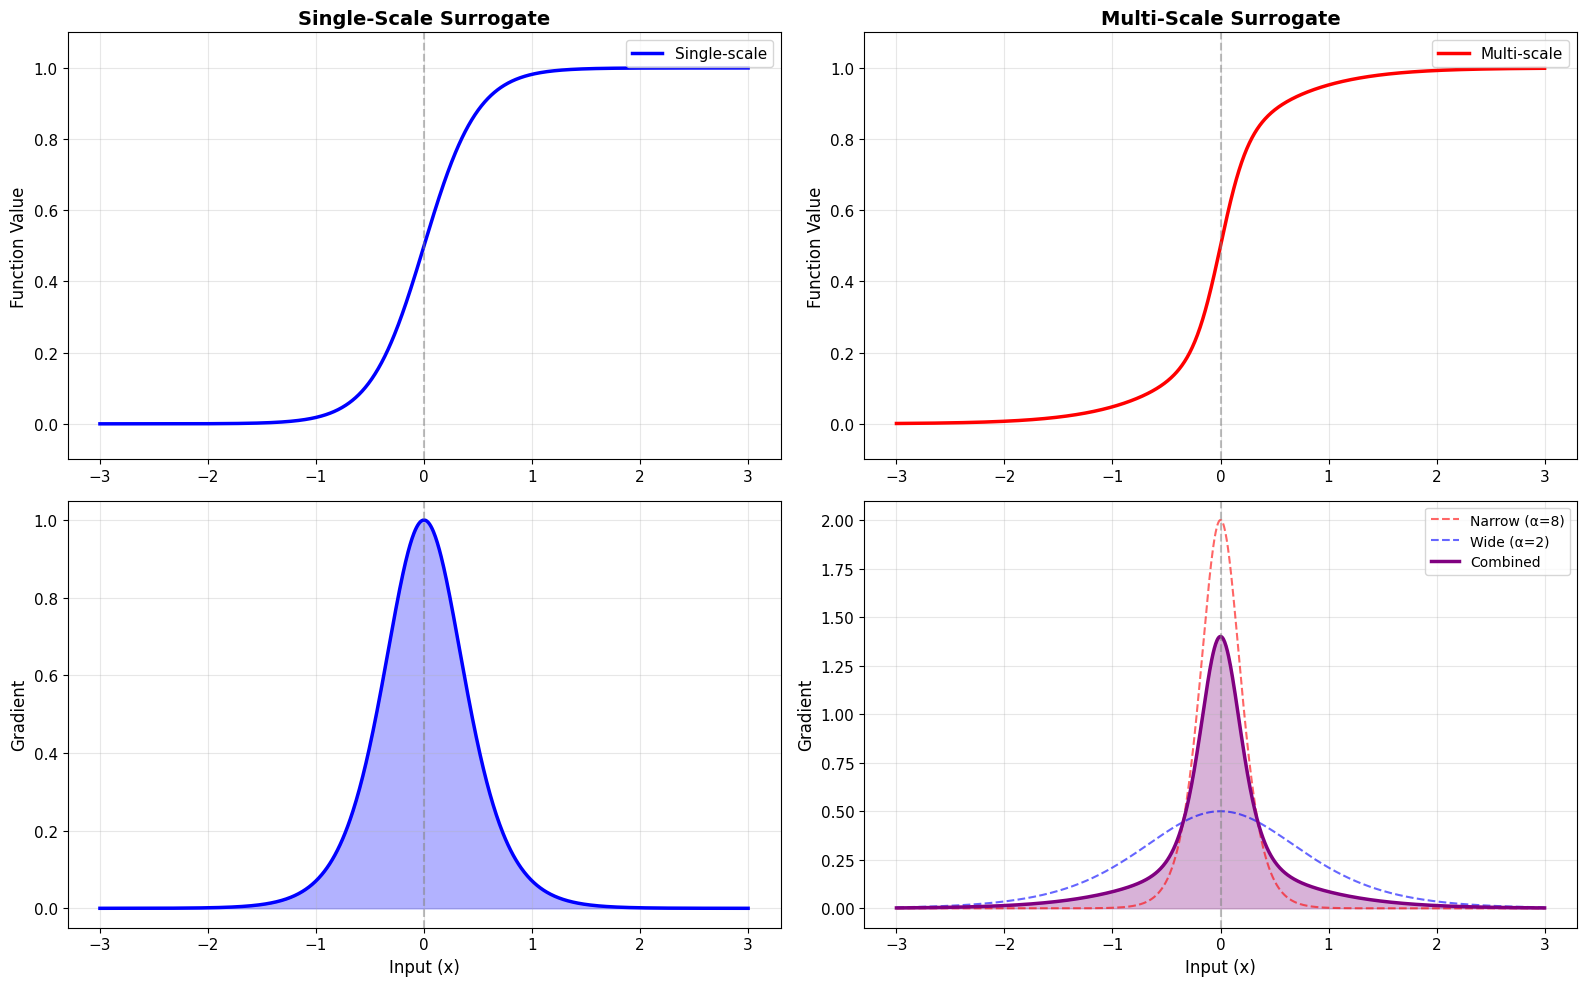


✅ Multi-scale surrogate combines best of both worlds:
   • Narrow component: Precise gradients near threshold
   • Wide component: Broad gradient coverage

Benefits:
• Better gradient flow for far-from-threshold neurons
• Maintains precision near threshold
• Can improve training in deep SNNs


In [5]:
# Multi-scale surrogate combining narrow and wide gradients
print("=== MULTI-SCALE SURROGATE ===")

class MultiScaleSurrogate(surrogate.Surrogate):
    """Combination of narrow and wide surrogates."""
    
    def __init__(self, alpha_narrow=8.0, alpha_wide=2.0, weight_narrow=0.7):
        super().__init__()
        self.alpha_narrow = alpha_narrow
        self.alpha_wide = alpha_wide
        self.weight_narrow = weight_narrow
        self.weight_wide = 1.0 - weight_narrow
    
    def surrogate_fun(self, x):
        """Weighted combination of two sigmoids."""
        sig_narrow = 1.0 / (1.0 + jnp.exp(-self.alpha_narrow * x))
        sig_wide = 1.0 / (1.0 + jnp.exp(-self.alpha_wide * x))
        return self.weight_narrow * sig_narrow + self.weight_wide * sig_wide
    
    def surrogate_grad(self, x):
        """Weighted combination of gradients."""
        # Narrow component
        sig_n = 1.0 / (1.0 + jnp.exp(-self.alpha_narrow * x))
        grad_n = self.alpha_narrow * sig_n * (1.0 - sig_n)
        
        # Wide component
        sig_w = 1.0 / (1.0 + jnp.exp(-self.alpha_wide * x))
        grad_w = self.alpha_wide * sig_w * (1.0 - sig_w)
        
        return self.weight_narrow * grad_n + self.weight_wide * grad_w

# Compare with single-scale
single_scale = surrogate.Sigmoid(alpha=4.0)
multi_scale = MultiScaleSurrogate(alpha_narrow=8.0, alpha_wide=2.0, weight_narrow=0.6)

x = jnp.linspace(-3, 3, 1000)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Single-scale function
axes[0, 0].plot(x, single_scale.surrogate_fun(x), 'b-', linewidth=2.5, label='Single-scale')
axes[0, 0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_ylabel('Function Value', fontsize=12)
axes[0, 0].set_title('Single-Scale Surrogate', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(-0.1, 1.1)

# Single-scale gradient
axes[1, 0].plot(x, single_scale.surrogate_grad(x), 'b-', linewidth=2.5)
axes[1, 0].fill_between(x, 0, single_scale.surrogate_grad(x), alpha=0.3, color='blue')
axes[1, 0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Input (x)', fontsize=12)
axes[1, 0].set_ylabel('Gradient', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Multi-scale function
axes[0, 1].plot(x, multi_scale.surrogate_fun(x), 'r-', linewidth=2.5, label='Multi-scale')
axes[0, 1].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].set_ylabel('Function Value', fontsize=12)
axes[0, 1].set_title('Multi-Scale Surrogate', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(-0.1, 1.1)

# Multi-scale gradient with components
sig_n = 1.0 / (1.0 + jnp.exp(-8.0 * x))
grad_n = 8.0 * sig_n * (1.0 - sig_n)
sig_w = 1.0 / (1.0 + jnp.exp(-2.0 * x))
grad_w = 2.0 * sig_w * (1.0 - sig_w)

axes[1, 1].plot(x, grad_n, 'r--', linewidth=1.5, alpha=0.6, label='Narrow (α=8)')
axes[1, 1].plot(x, grad_w, 'b--', linewidth=1.5, alpha=0.6, label='Wide (α=2)')
axes[1, 1].plot(x, multi_scale.surrogate_grad(x), 'purple', linewidth=2.5, label='Combined')
axes[1, 1].fill_between(x, 0, multi_scale.surrogate_grad(x), alpha=0.3, color='purple')
axes[1, 1].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Input (x)', fontsize=12)
axes[1, 1].set_ylabel('Gradient', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Multi-scale surrogate combines best of both worlds:")
print("   • Narrow component: Precise gradients near threshold")
print("   • Wide component: Broad gradient coverage")
print("\nBenefits:")
print("• Better gradient flow for far-from-threshold neurons")
print("• Maintains precision near threshold")
print("• Can improve training in deep SNNs")

## 4. Functional API for Custom Surrogates

You can also create surrogates using JAX custom gradients without defining classes:

=== FUNCTIONAL SURROGATE API ===


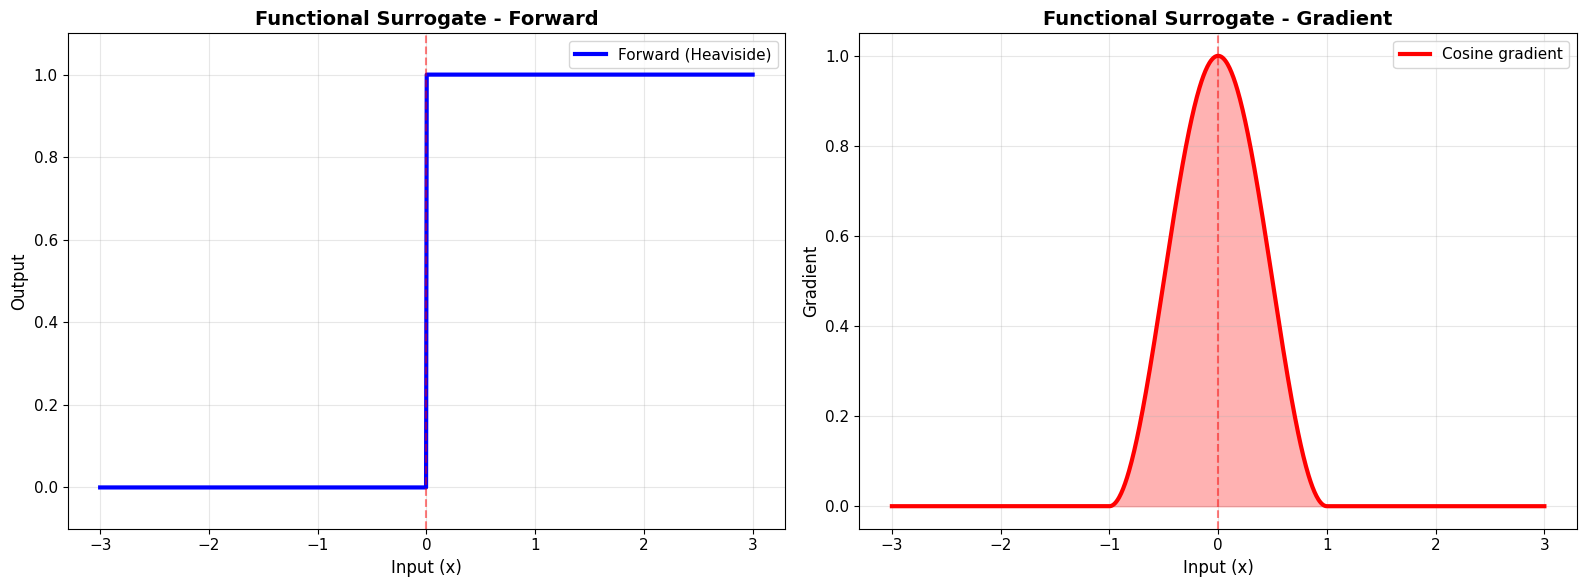


✅ Functional API provides flexibility without class overhead

Advantages:
• Quick prototyping
• Easy to compose
• Full JAX compatibility


In [6]:
# Create surrogate using JAX custom_vjp (functional approach)
print("=== FUNCTIONAL SURROGATE API ===")

def create_custom_surrogate(grad_fn):
    """Factory function to create surrogate with custom gradient."""
    
    @jax.custom_vjp
    def spike_fn(x):
        # Forward: Heaviside step
        return jnp.where(x >= 0, 1.0, 0.0)
    
    def spike_fn_fwd(x):
        return spike_fn(x), x
    
    def spike_fn_bwd(x, g):
        # Backward: custom gradient
        return (g * grad_fn(x),)
    
    spike_fn.defvjp(spike_fn_fwd, spike_fn_bwd)
    return spike_fn

# Example: Cosine gradient
def cosine_grad(x, width=1.0):
    """Cosine-shaped gradient."""
    return jnp.where(
        jnp.abs(x) < width,
        (jnp.cos(jnp.pi * x / width) + 1.0) / 2.0,
        0.0
    )

# Create functional surrogate
cosine_spike = create_custom_surrogate(cosine_grad)

# Test it
x = jnp.linspace(-3, 3, 1000)
forward = jax.vmap(cosine_spike)(x)
gradient = jax.vmap(jax.grad(lambda x: cosine_spike(x)))(x)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Forward
axes[0].plot(x, forward, 'b-', linewidth=3, label='Forward (Heaviside)')
axes[0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Input (x)', fontsize=12)
axes[0].set_ylabel('Output', fontsize=12)
axes[0].set_title('Functional Surrogate - Forward', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.1, 1.1)

# Gradient
axes[1].plot(x, gradient, 'r-', linewidth=3, label='Cosine gradient')
axes[1].fill_between(x, 0, gradient, alpha=0.3, color='red')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Input (x)', fontsize=12)
axes[1].set_ylabel('Gradient', fontsize=12)
axes[1].set_title('Functional Surrogate - Gradient', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Functional API provides flexibility without class overhead")
print("\nAdvantages:")
print("• Quick prototyping")
print("• Easy to compose")
print("• Full JAX compatibility")

## 5. Adaptive Surrogates

Create surrogates that adapt based on training dynamics:

=== ADAPTIVE TEMPERATURE-SCALED SURROGATE ===


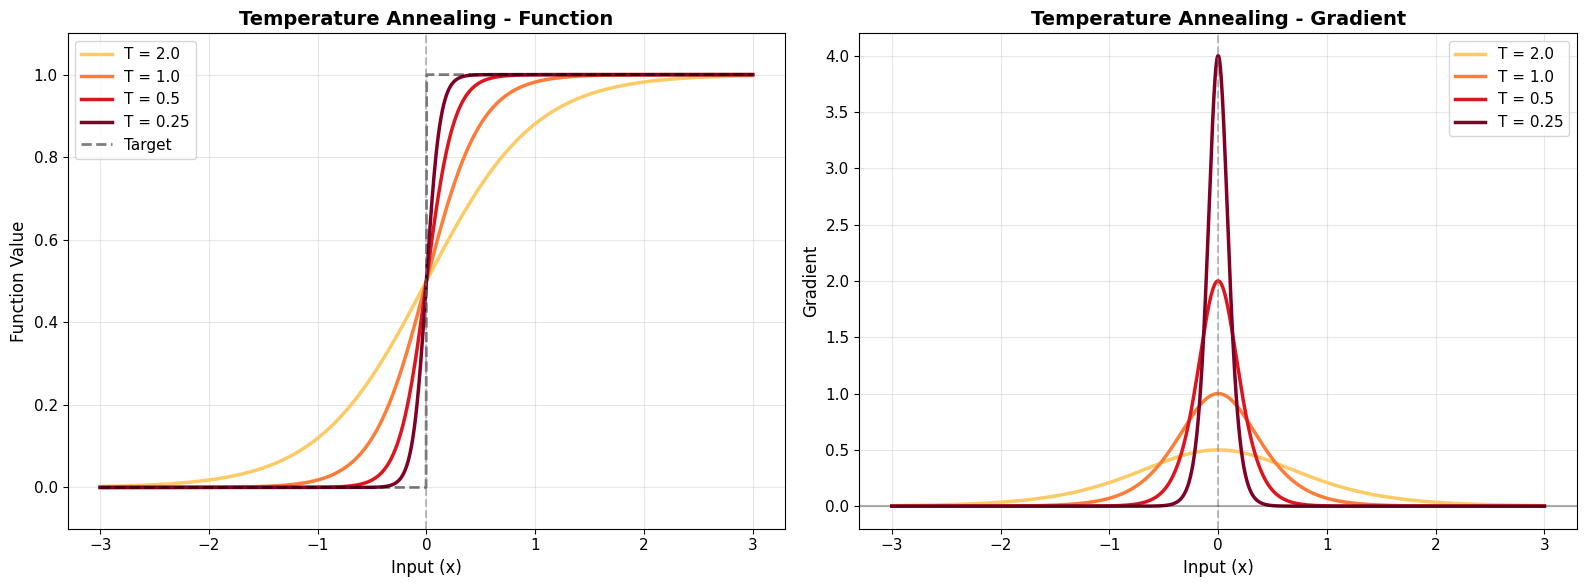


✅ Temperature annealing strategy:
   1. Start with high T (soft, wide gradients) → easier learning
   2. Gradually decrease T → sharper approximation
   3. End with low T (steep, precise) → closer to Heaviside

Usage:
   sg = TemperatureScaledSurrogate()
   # During training loop:
   sg.set_temperature(initial_temp * (0.95 ** epoch))


In [7]:
# Temperature-scaled surrogate (common in annealing)
print("=== ADAPTIVE TEMPERATURE-SCALED SURROGATE ===")

class TemperatureScaledSurrogate(surrogate.Surrogate):
    """Surrogate with temperature scaling (annealing)."""
    
    def __init__(self, alpha=4.0, temperature=1.0):
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
    
    def surrogate_fun(self, x):
        """Temperature-scaled sigmoid."""
        return 1.0 / (1.0 + jnp.exp(-self.alpha * x / self.temperature))
    
    def surrogate_grad(self, x):
        """Temperature-scaled gradient."""
        sig = self.surrogate_fun(x)
        return (self.alpha / self.temperature) * sig * (1.0 - sig)
    
    def set_temperature(self, temp):
        """Update temperature (e.g., during training)."""
        self.temperature = temp

# Demonstrate temperature annealing
temperatures = [2.0, 1.0, 0.5, 0.25]
x = jnp.linspace(-3, 3, 1000)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.YlOrRd(np.linspace(0.3, 1.0, len(temperatures)))

for temp, color in zip(temperatures, colors):
    sg = TemperatureScaledSurrogate(alpha=4.0, temperature=temp)
    
    axes[0].plot(x, sg.surrogate_fun(x), linewidth=2.5, 
                color=color, label=f'T = {temp}')
    axes[1].plot(x, sg.surrogate_grad(x), linewidth=2.5, 
                color=color, label=f'T = {temp}')

# Function
axes[0].plot(x, jnp.where(x >= 0, 1.0, 0.0), 'k--', linewidth=2, alpha=0.5, label='Target')
axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Input (x)', fontsize=12)
axes[0].set_ylabel('Function Value', fontsize=12)
axes[0].set_title('Temperature Annealing - Function', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.1, 1.1)

# Gradient
axes[1].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(0, color='black', linestyle='-', alpha=0.3)
axes[1].set_xlabel('Input (x)', fontsize=12)
axes[1].set_ylabel('Gradient', fontsize=12)
axes[1].set_title('Temperature Annealing - Gradient', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Temperature annealing strategy:")
print("   1. Start with high T (soft, wide gradients) → easier learning")
print("   2. Gradually decrease T → sharper approximation")
print("   3. End with low T (steep, precise) → closer to Heaviside")
print("\nUsage:")
print("   sg = TemperatureScaledSurrogate()")
print("   # During training loop:")
print("   sg.set_temperature(initial_temp * (0.95 ** epoch))")

## 6. Task-Specific Surrogates

### Example: Sparse Coding Surrogate

Design a surrogate that encourages sparsity:

=== SPARSITY-PROMOTING SURROGATE ===


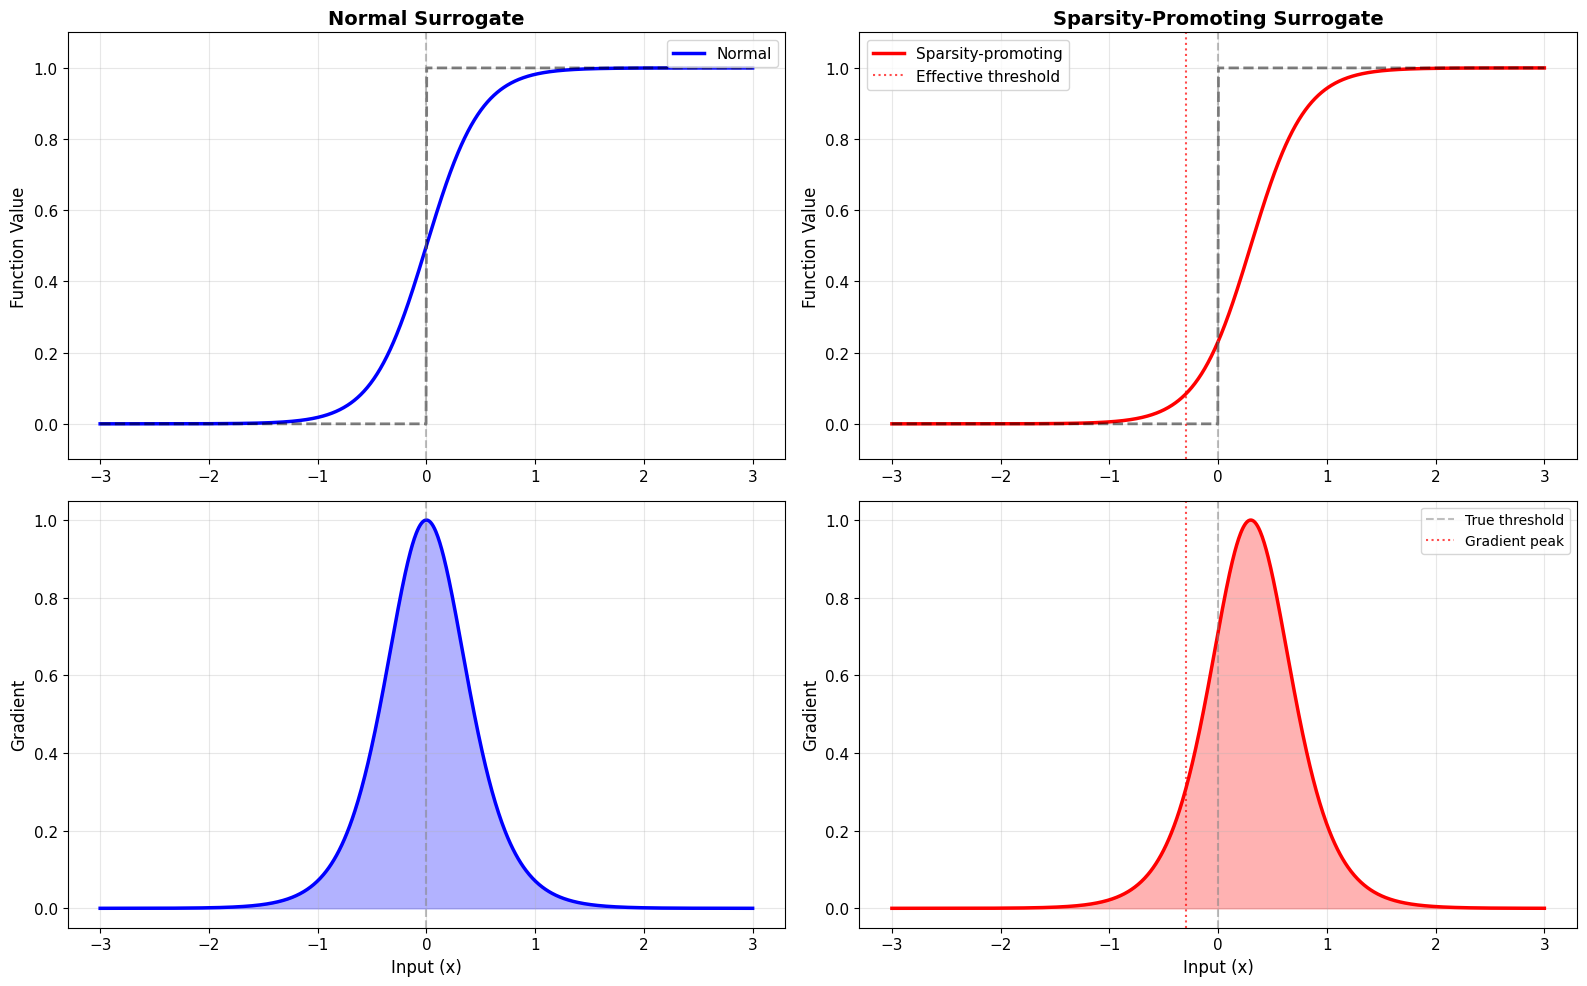


✅ Sparsity-promoting surrogate:
   • Shifts gradient peak below threshold
   • Requires higher input to spike
   • Reduces overall firing rate

Use cases:
   • Energy-efficient SNNs
   • Sparse event-based processing
   • Biological realism (low firing rates)


In [8]:
# Surrogate designed for sparse spiking
print("=== SPARSITY-PROMOTING SURROGATE ===")

class SparsitySurrogate(surrogate.Surrogate):
    """Surrogate that promotes sparse spiking."""
    
    def __init__(self, alpha=4.0, bias=-0.5):
        super().__init__()
        self.alpha = alpha
        self.bias = bias  # Negative bias discourages spiking
    
    def surrogate_fun(self, x):
        """Biased sigmoid."""
        return 1.0 / (1.0 + jnp.exp(-self.alpha * (x + self.bias)))
    
    def surrogate_grad(self, x):
        """Asymmetric gradient."""
        sig = self.surrogate_fun(x)
        return self.alpha * sig * (1.0 - sig)

# Compare normal vs sparsity-promoting
normal_sg = surrogate.Sigmoid(alpha=4.0)
sparse_sg = SparsitySurrogate(alpha=4.0, bias=-0.3)

x = jnp.linspace(-3, 3, 1000)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Functions
axes[0, 0].plot(x, normal_sg.surrogate_fun(x), 'b-', linewidth=2.5, label='Normal')
axes[0, 0].plot(x, jnp.where(x >= 0, 1.0, 0.0), 'k--', linewidth=2, alpha=0.5)
axes[0, 0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 0].set_ylabel('Function Value', fontsize=12)
axes[0, 0].set_title('Normal Surrogate', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(-0.1, 1.1)

axes[0, 1].plot(x, sparse_sg.surrogate_fun(x), 'r-', linewidth=2.5, label='Sparsity-promoting')
axes[0, 1].plot(x, jnp.where(x >= 0, 1.0, 0.0), 'k--', linewidth=2, alpha=0.5)
axes[0, 1].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0, 1].axvline(-0.3, color='red', linestyle=':', alpha=0.7, label='Effective threshold')
axes[0, 1].set_ylabel('Function Value', fontsize=12)
axes[0, 1].set_title('Sparsity-Promoting Surrogate', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(-0.1, 1.1)

# Gradients
axes[1, 0].plot(x, normal_sg.surrogate_grad(x), 'b-', linewidth=2.5)
axes[1, 0].fill_between(x, 0, normal_sg.surrogate_grad(x), alpha=0.3, color='blue')
axes[1, 0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Input (x)', fontsize=12)
axes[1, 0].set_ylabel('Gradient', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(x, sparse_sg.surrogate_grad(x), 'r-', linewidth=2.5)
axes[1, 1].fill_between(x, 0, sparse_sg.surrogate_grad(x), alpha=0.3, color='red')
axes[1, 1].axvline(0, color='gray', linestyle='--', alpha=0.5, label='True threshold')
axes[1, 1].axvline(-0.3, color='red', linestyle=':', alpha=0.7, label='Gradient peak')
axes[1, 1].set_xlabel('Input (x)', fontsize=12)
axes[1, 1].set_ylabel('Gradient', fontsize=12)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Sparsity-promoting surrogate:")
print("   • Shifts gradient peak below threshold")
print("   • Requires higher input to spike")
print("   • Reduces overall firing rate")
print("\nUse cases:")
print("   • Energy-efficient SNNs")
print("   • Sparse event-based processing")
print("   • Biological realism (low firing rates)")

## 7. Real-World Application: Custom Surrogate for Event Camera Data

=== EVENT CAMERA SURROGATE ===


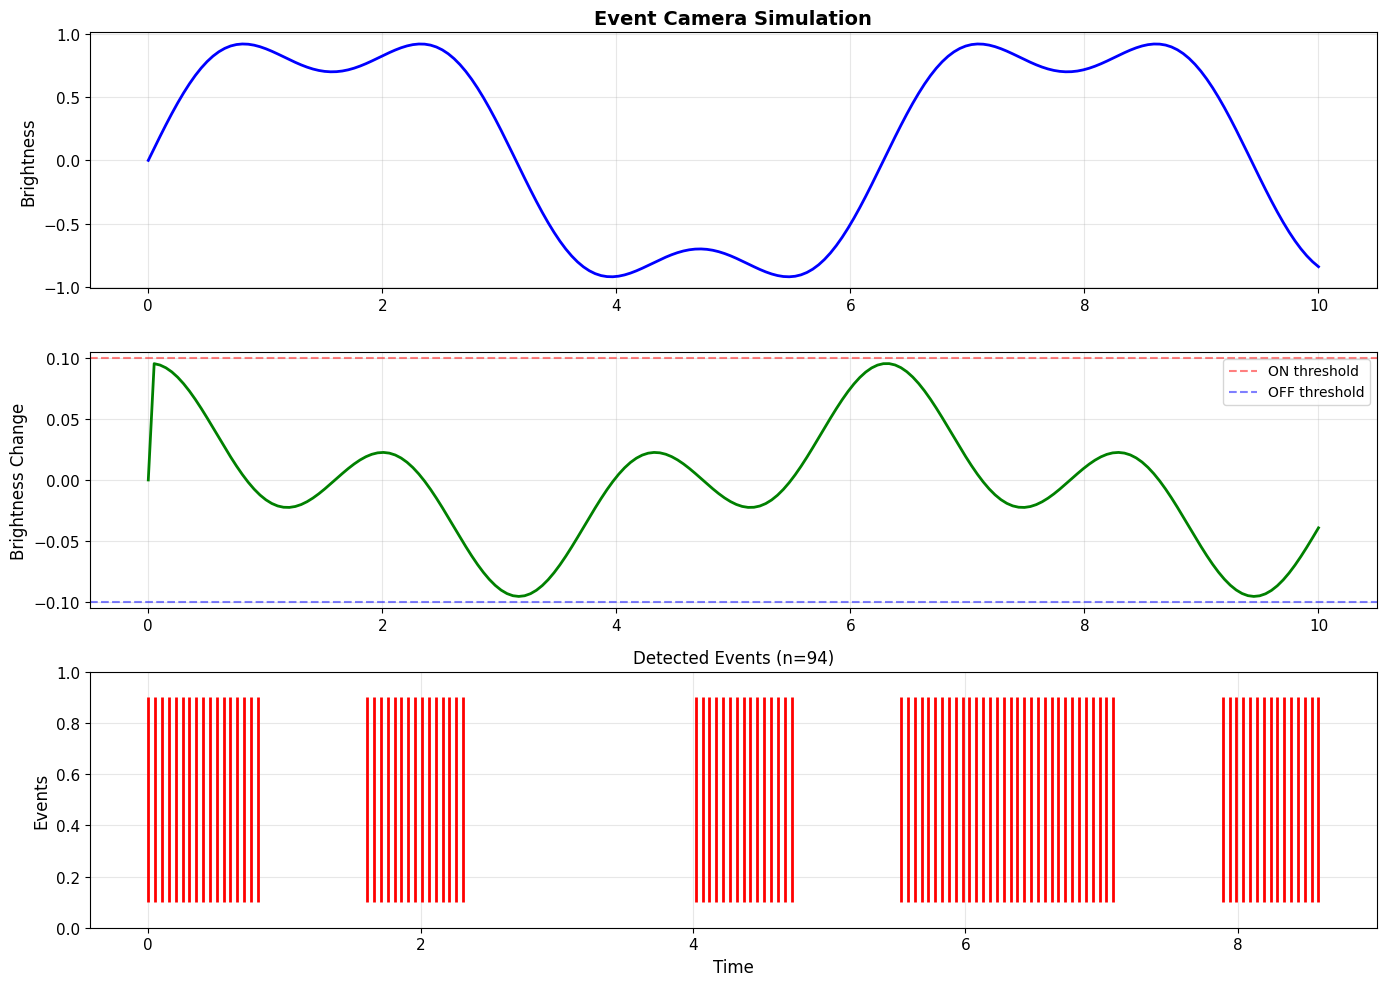


✅ Event camera surrogate:
   • Detected 94 events
   • Differentiable event detection
   • Can be trained end-to-end


In [11]:
# Event camera surrogate with polarity
print("=== EVENT CAMERA SURROGATE ===")

class EventCameraSurrogate(surrogate.Surrogate):
    """Surrogate for event camera data (ON/OFF events)."""
    
    def __init__(self, alpha=4.0, on_threshold=0.0, off_threshold=0.0):
        super().__init__()
        self.alpha = alpha
        self.on_threshold = on_threshold
        self.off_threshold = off_threshold
    
    def surrogate_fun(self, x):
        """Approximates ON event detection."""
        return 1.0 / (1.0 + jnp.exp(-self.alpha * (x - self.on_threshold)))
    
    def surrogate_grad(self, x):
        """Gradient for ON events."""
        sig = self.surrogate_fun(x)
        return self.alpha * sig * (1.0 - sig)

# Simulate event camera change detection
def simulate_event_camera(signal, surrogate_fn):
    """Simulate event camera using surrogate gradient."""
    changes = jnp.diff(signal, prepend=signal[0])
    events = jax.vmap(surrogate_fn)(changes)
    return events

# Create test signal (brightness changes)
t = jnp.linspace(0, 10, 200)
signal = jnp.sin(t) + 0.3 * jnp.sin(3 * t)

# Detect events
event_sg = EventCameraSurrogate(alpha=10.0, on_threshold=0.1)
events = simulate_event_camera(signal, event_sg)

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original signal
axes[0].plot(t, signal, 'b-', linewidth=2)
axes[0].set_ylabel('Brightness', fontsize=12)
axes[0].set_title('Event Camera Simulation', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Changes
changes = jnp.diff(signal, prepend=signal[0])
axes[1].plot(t, changes, 'g-', linewidth=2)
axes[1].axhline(0.1, color='r', linestyle='--', alpha=0.5, label='ON threshold')
axes[1].axhline(-0.1, color='b', linestyle='--', alpha=0.5, label='OFF threshold')
axes[1].set_ylabel('Brightness Change', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Events
event_times = t[events > 0.5]
axes[2].eventplot(event_times, lineoffsets=0.5, linelengths=0.8, linewidths=2, color='red')
axes[2].set_xlabel('Time', fontsize=12)
axes[2].set_ylabel('Events', fontsize=12)
axes[2].set_ylim(0, 1)
axes[2].set_title(f'Detected Events (n={jnp.sum(events > 0.5):.0f})', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Event camera surrogate:")
print(f"   • Detected {jnp.sum(events > 0.5):.0f} events")
print(f"   • Differentiable event detection")
print(f"   • Can be trained end-to-end")

## Summary


When creating a custom surrogate:

- [ ] Inherits from `surrogate.Surrogate`
- [ ] Implements `surrogate_fun(x)` (smooth approximation)
- [ ] Implements `surrogate_grad(x)` (gradient)
- [ ] Function is monotonically increasing
- [ ] Gradient is non-negative
- [ ] Peak gradient near threshold (x=0)
- [ ] Numerically stable (no NaN/Inf)
- [ ] Works with different array shapes
- [ ] JIT-compatible
- [ ] Tested with `jax.grad`
- [ ] Documented parameters

Quick Reference

```python
# Template for custom surrogate
class MySurrogate(surrogate.Surrogate):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha
    
    def surrogate_fun(self, x):
        # Return smooth approximation
        return ...
    
    def surrogate_grad(self, x):
        # Return gradient
        return ...

# Use it
sg = MySurrogate(alpha=4.0)
spike = sg(membrane_potential - threshold)
```